In [11]:
import pandas as pd
import nltk
import numpy as np
from nltk.tokenize import RegexpTokenizer
from autocorrect import Speller
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.multioutput import MultiOutputClassifier
from sklearn.svm import LinearSVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score, ConfusionMatrixDisplay, f1_score, classification_report, plot_roc_curve, roc_curve, auc
import scipy.stats
import math
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
import pandas as pd
import myutils
from itertools import cycle
from scipy import interp
import pickle

spell = Speller(lang='en')
nltk.download('stopwords')
nltk.download('punkt')
tk = RegexpTokenizer(r'\w+')


schemas = ["vulnerable", "angry", "impulsive", "happy", "detached", "punishing", "healthy"]
num_of_schemas = 7
max_words = 2000
max_epochs = 30
vec_size = 500

[nltk_data] Downloading package stopwords to C:\Users\Irene
[nltk_data]     Park\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Irene
[nltk_data]     Park\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# SVM Binary Classification
In total three kernels, linear, polynomial and RBF will be tested.

Accuracy:  0.40096618357487923
F1 Score:  0.48980737252736894
              precision    recall  f1-score   support

  vulnerable       0.00      0.00      0.00        65
       angry       0.00      0.00      0.00        83
   impulsive       0.00      0.00      0.00        40
       happy       0.75      1.00      0.86       156
    detached       0.00      0.00      0.00        68
   punishing       0.00      0.00      0.00        47
     healthy       0.93      1.00      0.96       192

   micro avg       0.83      0.53      0.65       651
   macro avg       0.24      0.29      0.26       651
weighted avg       0.45      0.53      0.49       651
 samples avg       0.84      0.65      0.70       651

\begin{table}
\caption{Latex Table from Classification Report}
\label{table:classification:report}
\centering
\begin{tabular}{c | c c c r}
Class & Precision & Recall & F-score & Support\\
\midrule
vulnerable & 0.0 & 0.0 & 0.0 & 65\\
angry & 0.0 & 0.0 & 0.0 & 83\\
impulsive & 0.0 & 0.0 &

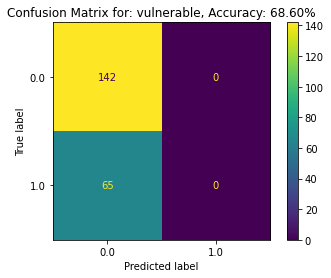

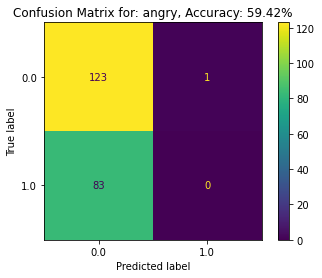

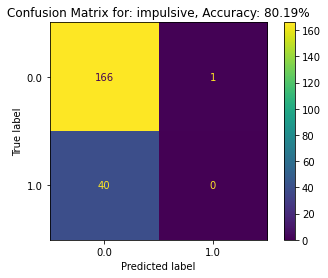

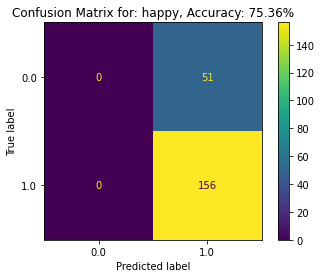

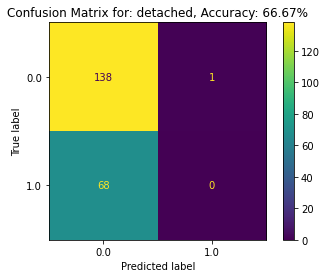

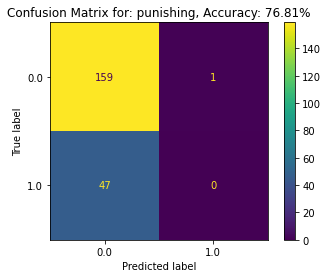

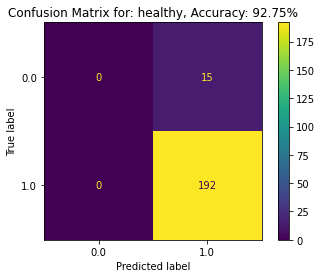

Schemas:  ['vulnerable', 'angry', 'impulsive', 'happy', 'detached', 'punishing', 'healthy']
Sum: [ 352.  430.  191.  852.  391.  239. 1106.]
Accuracy:  [0.6859903381642513, 0.5942028985507246, 0.8019323671497585, 0.7536231884057971, 0.6666666666666666, 0.7681159420289855, 0.927536231884058]
None


In [15]:
def svm_linear():
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = myutils.get_text_labels(df)
    x_train, y_train, x_test, y_test, test_percent = myutils.split_data(texts, labels, 0.15)

    processed, tokenized = myutils.pre_process_data(x_train) 
    fastText_model = myutils.training_model_fast_text()
    x_train_vectors = []
    for row in range(len(x_train)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_train_vectors.append(row_vec)
        else:
            x_train_vectors.append(row_vec)

    x_train = np.asarray(x_train_vectors)
    y_train = np.asarray(y_train)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)

    model_to_set = svm.SVC(kernel="linear")
    multilabel_classifier = MultiOutputClassifier(model_to_set, n_jobs=-1)
    multilabel_classifier = multilabel_classifier.fit(x_train, y_train)

    processed, tokenized = myutils.pre_process_data(x_test) 
    x_test_vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_test_vectors.append(row_vec)
        else:
            x_test_vectors.append(row_vec)

    x_test = np.asarray(x_test_vectors)
    y_test = np.asarray(y_test)
    x_test = scaler.transform(x_test)

    schema_test_pred = multilabel_classifier.predict(x_test)
    print("Accuracy: ", accuracy_score(y_test, schema_test_pred))
    print('F1 Score: ', f1_score(y_test, schema_test_pred, average='weighted'))
    clf_report = classification_report(y_test, schema_test_pred, target_names=schemas)
    print(clf_report)


    clf_report_data = myutils.parse_classification_report(clf_report)
    print(myutils.report_to_latex_table(clf_report_data))
    each_accuracy = []
    # Generate multiclass confusion matrices
    matrices = multilabel_confusion_matrix(y_test, schema_test_pred)
    # Plotting matrices: code
    i = 1
    for mat in matrices:
        cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(y_test)).plot()
        accuracy_calc = accuracy_score(y_true=y_test[:,i-1], y_pred=schema_test_pred[:,i-1])
        each_accuracy.append(accuracy_calc)
        plt.title('Confusion Matrix for: ' + str(schemas[i-1]) + ", Accuracy: " + "{:.2%}".format(accuracy_calc))
        plt.show()
        i += 1
    
    print("Schemas: ", schemas)
    print("Sum:", np.sum(y_train, axis=0))
    print("Accuracy: ", each_accuracy)
    

print(svm_linear())

length of labels: 1375
Accuracy:  0.3333333333333333
F1 Score:  0.5107246188743908
              precision    recall  f1-score   support

  vulnerable       0.15      0.03      0.05        65
       angry       0.18      0.04      0.06        83
   impulsive       0.09      0.03      0.04        40
       happy       0.75      0.94      0.84       156
    detached       0.25      0.06      0.10        68
   punishing       0.11      0.02      0.04        47
     healthy       0.93      0.99      0.96       192

   micro avg       0.75      0.53      0.62       651
   macro avg       0.35      0.30      0.30       651
weighted avg       0.53      0.53      0.51       651
 samples avg       0.80      0.65      0.68       651

\begin{table}
\caption{Latex Table from Classification Report}
\label{table:classification:report}
\centering
\begin{tabular}{c | c c c r}
Class & Precision & Recall & F-score & Support\\
\midrule
vulnerable & 0.15 & 0.03 & 0.05 & 65\\
angry & 0.18 & 0.04 & 0.06 & 8

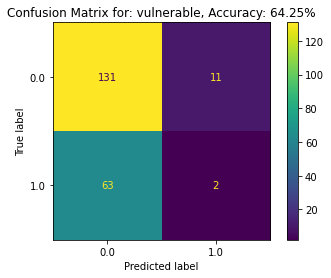

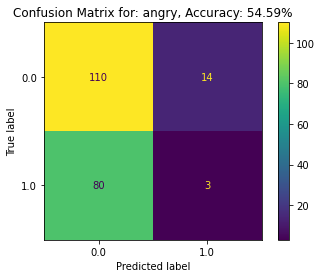

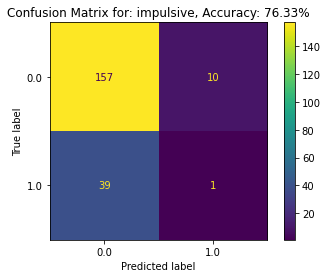

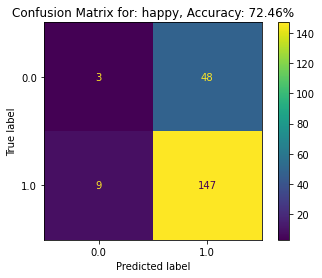

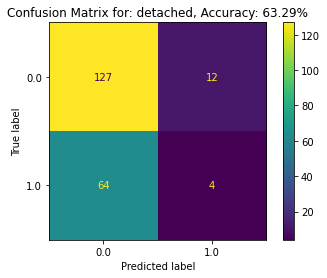

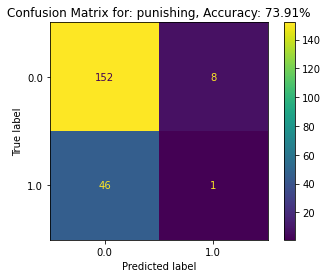

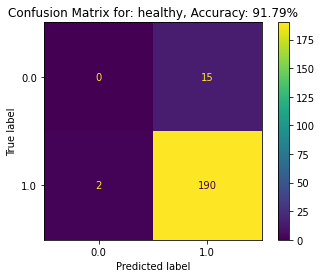

Schemas:  ['vulnerable', 'angry', 'impulsive', 'happy', 'detached', 'punishing', 'healthy']
Sum: [ 352.  430.  191.  852.  391.  239. 1106.]
Sum 2: [ 65.  83.  40. 156.  68.  47. 192.]
Accuracy:  [0.642512077294686, 0.5458937198067633, 0.7632850241545893, 0.7246376811594203, 0.6328502415458938, 0.7391304347826086, 0.9178743961352657]
None


In [16]:
def svm_poly():
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = myutils.get_text_labels(df)
    x_train, y_train, x_test, y_test, test_percent = myutils.split_data(texts, labels, 0.15)
    print("length of labels:", len(labels))

    processed, tokenized = myutils.pre_process_data(x_train) 
    fastText_model = myutils.training_model_fast_text()
    x_train_vectors = []
    for row in range(len(x_train)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_train_vectors.append(row_vec)
        else:
            x_train_vectors.append(row_vec)

    x_train = np.asarray(x_train_vectors)
    y_train = np.asarray(y_train)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)

    model_to_set = svm.SVC(kernel="poly")
    multilabel_classifier = MultiOutputClassifier(model_to_set, n_jobs=-1)
    multilabel_classifier = multilabel_classifier.fit(x_train, y_train)

    processed, tokenized = myutils.pre_process_data(x_test) 
    x_test_vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_test_vectors.append(row_vec)
        else:
            x_test_vectors.append(row_vec)

    x_test = np.asarray(x_test_vectors)
    y_test = np.asarray(y_test)
    x_test = scaler.transform(x_test)

    schema_test_pred = multilabel_classifier.predict(x_test)
    print("Accuracy: ", accuracy_score(y_test, schema_test_pred))
    print('F1 Score: ', f1_score(y_test, schema_test_pred, average='weighted'))
    clf_report = classification_report(y_test, schema_test_pred, target_names=schemas)
    print(clf_report)

    clf_report_data = myutils.parse_classification_report(clf_report)
    print(myutils.report_to_latex_table(clf_report_data))

    each_accuracy = []
    # Generate multiclass confusion matrices
    matrices = multilabel_confusion_matrix(y_test, schema_test_pred)
    # Plotting matrices: code
    i = 1
    for mat in matrices:
        cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(y_test)).plot()
        accuracy_calc = accuracy_score(y_true=y_test[:,i-1], y_pred=schema_test_pred[:,i-1])
        each_accuracy.append(accuracy_calc)
        plt.title('Confusion Matrix for: ' + str(schemas[i-1]) + ", Accuracy: " + "{:.2%}".format(accuracy_calc))
        plt.savefig('../plots/svm/poly/' +  str(schemas[i-1]))
        plt.show()
        i += 1
    
    print("Schemas: ", schemas)
    print("Sum:", np.sum(y_train, axis=0))
    print("Sum 2:", np.sum(y_test, axis=0))
    print("Accuracy: ", each_accuracy)

print(svm_poly())

length of labels: 1375
[[0. 0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 1. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0. 1. 1.]
 [0. 1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1.]
 [1. 0. 0. 0. 0. 1. 1.]
 [0. 1. 0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 1. 0. 1.]
 [1. 1. 1. 1. 1. 1. 1.]
 [0. 0. 0. 1. 0. 0. 1.]
 [1. 1. 0. 1. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 1.]
 [1. 1. 0. 1. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1.]]
Accuracy:  0.3526570048309179
F1 Score:  0.5096830612857488
              precision    recall  f1-score   support

  vulnerable       0.25      0.03      0.05        65
       angry       0.08      0.01      0.02        83
   impulsive       0.17      0.03      0.04        40
       happy       0.75      0.96      0.85       156
    detached       0.33      0.06      0.10        68
   punishing       0.25      0.02      0.04        47
     healthy       0.93      0.99      0.96       192

  

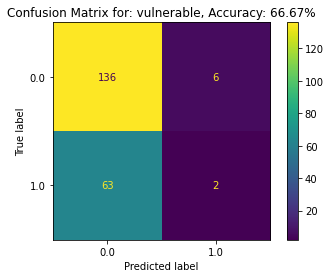

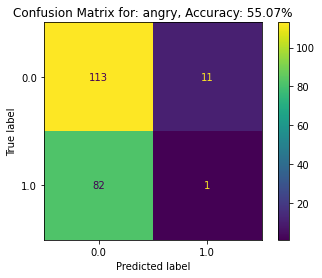

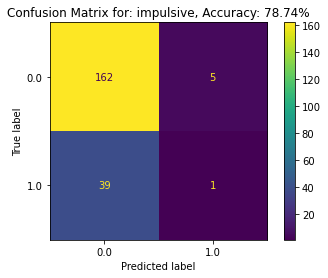

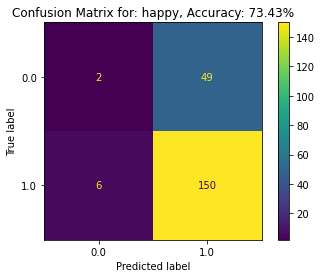

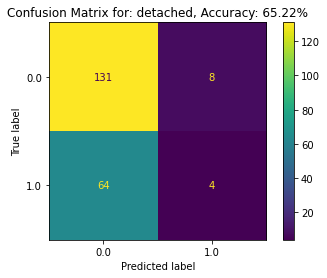

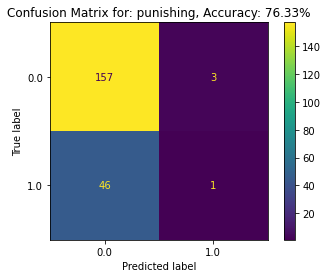

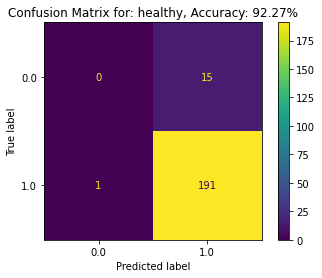

Schemas:  ['vulnerable', 'angry', 'impulsive', 'happy', 'detached', 'punishing', 'healthy']
Sum: [ 352.  430.  191.  852.  391.  239. 1106.]
Sum 2: [ 65.  83.  40. 156.  68.  47. 192.]
Accuracy:  [0.6666666666666666, 0.5507246376811594, 0.7874396135265701, 0.7342995169082126, 0.6521739130434783, 0.7632850241545893, 0.9227053140096618]
None


In [18]:
def svm_rbf():
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = myutils.get_text_labels(df)
    x_train, y_train, x_test, y_test, test_percent = myutils.split_data(texts, labels, 0.15)
    print("length of labels:", len(labels))

    processed, tokenized = myutils.pre_process_data(x_train) 
    fastText_model = myutils.training_model_fast_text()
    x_train_vectors = []
    for row in range(len(x_train)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_train_vectors.append(row_vec)
        else:
            x_train_vectors.append(row_vec)

    x_train = np.asarray(x_train_vectors)
    y_train = np.asarray(y_train)
    print(y_train[:20])
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)

    model_to_set = svm.SVC(kernel="rbf")
    multilabel_classifier = MultiOutputClassifier(model_to_set, n_jobs=-1)
    multilabel_classifier = multilabel_classifier.fit(x_train, y_train)

    processed, tokenized = myutils.pre_process_data(x_test) 
    x_test_vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_test_vectors.append(row_vec)
        else:
            x_test_vectors.append(row_vec)

    x_test = np.asarray(x_test_vectors)
    y_test = np.asarray(y_test)
    x_test = scaler.transform(x_test)

    schema_test_pred = multilabel_classifier.predict(x_test)
    print("Accuracy: ", accuracy_score(y_test, schema_test_pred))
    print('F1 Score: ', f1_score(y_test, schema_test_pred, average='weighted'))
    clf_report = classification_report(y_test, schema_test_pred, target_names=schemas)
    print(clf_report)

    clf_report_data = myutils.parse_classification_report(clf_report)
    print(myutils.report_to_latex_table(clf_report_data))

    each_accuracy = []
    # Generate multiclass confusion matrices
    matrices = multilabel_confusion_matrix(y_test, schema_test_pred)
    # Plotting matrices: code
    i = 1
    for mat in matrices:
        cmd = ConfusionMatrixDisplay(mat, display_labels=np.unique(y_test)).plot()
        accuracy_calc = accuracy_score(y_true=y_test[:,i-1], y_pred=schema_test_pred[:,i-1])
        each_accuracy.append(accuracy_calc)
        plt.title('Confusion Matrix for: ' + str(schemas[i-1]) + ", Accuracy: " + "{:.2%}".format(accuracy_calc))
        plt.savefig('../plots/svm/rbf/' +  str(schemas[i-1]))
        plt.show()
        i += 1
    
    print("Schemas: ", schemas)
    print("Sum:", np.sum(y_train, axis=0))
    print("Sum 2:", np.sum(y_test, axis=0))
    print("Accuracy: ", each_accuracy)

print(svm_rbf())

# Binary ROC
The cell below is used to plot roc curve of binary classification using polynomial kernel which gives the best result.

<ipython-input-4-f28d09d5c6b4>:74: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


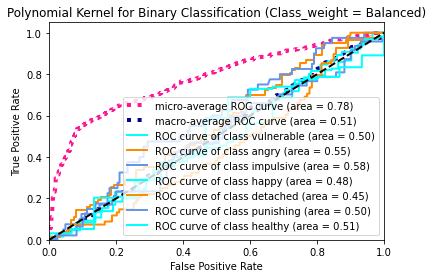

None


In [4]:
def svm_poly_roc():
    df = pd.read_csv("../data/FINAL_CSV.csv")
    texts, labels = myutils.get_text_labels(df)
    x_train, y_train, x_test, y_test, test_percent = myutils.split_data(texts, labels, 0.15)

    processed, tokenized = myutils.pre_process_data(x_train) 
    fastText_model = myutils.training_model_fast_text()
    x_train_vectors = []
    for row in range(len(x_train)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_train_vectors.append(row_vec)
        else:
            x_train_vectors.append(row_vec)

    x_train = np.asarray(x_train_vectors)
    y_train = np.asarray(y_train)
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)

    # from sklearn import preprocessing
    # x_train = preprocessing.scale(x_train) 
    #  C=0.1, gamma=0.1, degree=4
    model_to_set = svm.SVC(kernel="poly", class_weight='balanced', probability=True)
    multilabel_classifier = MultiOutputClassifier(model_to_set, n_jobs=-1)
    multilabel_classifier = multilabel_classifier.fit(x_train, y_train)

    processed, tokenized = myutils.pre_process_data(x_test) 
    x_test_vectors = []
    for row in range(len(tokenized)):
        words = texts[row]
        row_vec = np.zeros(fastText_model.get_dimension())
        for each in words:
            vector = fastText_model[each]
            row_vec = np.add(row_vec, vector)
        if len(words) > 0:
            row_vec /= len(words)
            x_test_vectors.append(row_vec)
        else:
            x_test_vectors.append(row_vec)

    x_test = np.asarray(x_test_vectors)
    y_test = np.asarray(y_test)
    x_test = scaler.transform(x_test)
    lw = 2
    schema_test_pred = multilabel_classifier.predict(x_test)

    y_score = multilabel_classifier.predict_proba(x_test)
    y_score = np.transpose([pred[:, 1] for pred in y_score])

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(num_of_schemas):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    # print("fpr: ", fpr)

    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # First aggregate all false positive rates
    all_fpr = np.unique(np.concatenate([fpr[i] for i in range(num_of_schemas)]))

    # Then interpolate all ROC curves at this points
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_of_schemas):
        mean_tpr += interp(all_fpr, fpr[i], tpr[i])

    # Finally average it and compute AUC
    mean_tpr /=num_of_schemas

    fpr["macro"] = all_fpr
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    # np.save('fpr.npy', fpr)
    # np.save('tpr.npy', tpr)
    # np.save('roc_auc.npy', roc_auc)
    # print(type(fpr))
    # a_file = open("fpr.json", "w")
    # json.dump(fpr, a_file)
    # a_file.close()

    fpr_file = open('fpr.pkl', 'wb')
    pickle.dump(fpr, fpr_file)   

    tpr_file = open('tpr.pkl', 'wb')
    pickle.dump(tpr, tpr_file)    
 
    roc_auc_file = open('roc_auc.pkl', 'wb')
    pickle.dump(roc_auc, roc_auc_file)  

    plt.figure()
    plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["micro"]),
            color='deeppink', linestyle=':', linewidth=4)

    plt.plot(fpr["macro"], tpr["macro"],
            label='macro-average ROC curve (area = {0:0.2f})'
                ''.format(roc_auc["macro"]),
            color='navy', linestyle=':', linewidth=4)

    colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
    for i, color in zip(range(num_of_schemas), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=lw,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(schemas[i], roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Polynomial Kernel for Binary Classification (Class_weight = Balanced)')
    plt.legend(loc="lower right")
    plt.show()

print(svm_poly_roc())